# Calibration, data analysis

In [18]:
#Import classic modules
# import numpy as np
# import matplotlib.pyplot as plt
import time


import qcodes as qc
from qcodes.logger.logger import start_all_logging
from qcodes.dataset.plotting import plot_dataset

import datetime
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from scipy.spatial.transform import Rotation as rot

import matplotlib.animation as animation

%matplotlib inline
#%matplotlib notebook

## Importation of the data from the database

In [19]:
start_all_logging()

Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\Vincent\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\Vincent\.qcodes\logs\200607-15008-qcodes.log


In [20]:
#define the name of the database in a sensible way
user = 'VJ'
date = str(datetime.date.today())
date='2020-04-15'
description = 'Calibration_Redpitaya_test'#'Through-device'#'STWPA_V03_10'
database_name = date+"_"+user+"_"+description

#Create or Initialize the database
qc.initialise_or_create_database_at("D:/Master Thesis/Calibration/Experimental/Data/"+database_name)

#We can ask "where is the database?"
qc.config.core.db_location

'D:/Master Thesis/Calibration/Experimental/Data/2020-04-15_VJ_Calibration_Redpitaya_test'

In [21]:
qc.experiments()

[Acquire_ADC_CH1 #w_p:5000000000.0-w_if:30000000.0-Pow:5-Phase:0-Period:0.04-IntLimit:0_1e-05-N_Pulse:10000#1@D:\Master Thesis\Calibration\Experimental\Data\2020-04-15_VJ_Calibration_Redpitaya_test
 ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 1-results-1-Redpitaya_time_axis,Redpitaya_ADC1-1]

In [22]:
captured_run_id=1

dataset = qc.load_by_run_spec(captured_run_id=captured_run_id)

data = dataset.get_parameter_data()
print(data)

{'Redpitaya_ADC1': {'Redpitaya_ADC1': array([[0.00805664, 0.01147461, 0.00683594, ..., 0.01266479, 0.00912476,
        0.01147461]]), 'Redpitaya_time_axis': array([[0.00000000e+00, 1.00000008e+00, 2.00000016e+00, ...,
        1.24999980e+07, 1.24999990e+07, 1.25000000e+07]])}}


In [23]:
w_p = dataset.get_metadata('w_p')
f_if = dataset.get_metadata('w_if')
Pow = dataset.get_metadata('pow')
phase = dataset.get_metadata('phase')
Period = dataset.get_metadata('Period')
t_init = dataset.get_metadata('t_init')
t_final = dataset.get_metadata('t_final')
N_Pulse = dataset.get_metadata('N_Pulse')

In [24]:
ADC1 = data['Redpitaya_ADC1']['Redpitaya_ADC1'][0]
Npoints = data['Redpitaya_ADC1']['Redpitaya_time_axis'][0]
time = Npoints*8e-9

In [25]:
#T = int(round(t_final/8e-9))-int(round(t_init/8e-9))
n = int(np.ceil((t_final-t_init)/8e-9))
pulse_length = n*8e-9
pulse_time = np.linspace(0,pulse_length,n)

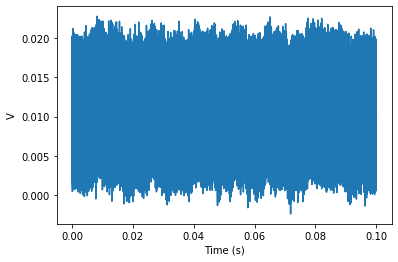

In [26]:
plt.plot(time,ADC1)
plt.xlabel('Time (s)')
plt.ylabel('V')
plt.show()

In [10]:
d_f = 35e6
f_if = 20e6
d_w = 2*np.pi*d_f
w_if = 2*np.pi*f_if

## Data analysis

First, let's define the integration time.

In [11]:
def IQpm(signal,d_wp,d_wm,t_int):
    #Cp stand for positive cosine, Sp positive sine, Cm negative cosine and Sm negative sine
    Cp = np.cos((w_if+d_wp)*pulse_time)
    Sp = np.sin((w_if+d_wp)*pulse_time)
    Cm = np.cos((w_if-d_wm)*pulse_time)
    Sm = np.sin((w_if-d_wm)*pulse_time)
    Qp = signal
    Ip = signal
    Qm = signal
    Im = signal
    #The 's' index here means, sequenced.
    Qps = []
    Ips = []
    Qms = []
    Ims = []

    for k in range(N_Pulse):
        Qps.append(Qp[int(np.ceil(k*n)):int(np.ceil((k+1)*n))]*Cp)
        Ips.append(Ip[int(np.ceil(k*n)):int(np.ceil((k+1)*n))]*Sp)
        Qms.append(Qm[int(np.ceil(k*n)):int(np.ceil((k+1)*n))]*Cm)
        Ims.append(Im[int(np.ceil(k*n)):int(np.ceil((k+1)*n))]*Sm)
        #The 'a' index here means, averaged.
    Qpa = []
    Ipa = []
    Qma = []
    Ima = []

    n_int = int(np.ceil((t_int)/8e-9))
    #Recheck normalization by duration time, to get proper dimensions in the end
    for k in range(N_Pulse):
        Qpa.append(np.average(Qps[k][0:n_int]))
        Ipa.append(np.average(Ips[k][0:n_int]))
        Qma.append(np.average(Qms[k][0:n_int]))
        Ima.append(np.average(Ims[k][0:n_int]))
    Qpa = np.asarray(Qpa)
    Ipa = np.asarray(Ipa)
    Qma = np.asarray(Qma)
    Ima = np.asarray(Ima)
    return Qpa, Ipa, Qma, Ima

In [12]:
def Cov2modes(signal,d_wp,d_wm,t_int):
    #Conversion to mV
    C = IQpm(signal,d_wp,d_wm,t_int)
    q1 = C[0]*1e3
    p1 = C[1]*1e3
#
    q2 = C[2]*1e3
    p2 = C[3]*1e3

    q1_m = np.average(q1)
    p1_m = np.average(p1)
    q2_m = np.average(q2)
    p2_m = np.average(p2)

    R = (q1_m, p1_m, q2_m, p2_m)
    R = np.array(R)

    s_11 = np.average(q1**2) - (np.average(q1))**2
    s_22 = np.average(p1**2) - (np.average(p1))**2
    s_12 = 0.5 *np.average(q1*p1 + p1*q1) - np.average(q1)*np.average(p1)
    s_21 = s_12

    A = np.array([[s_11, s_12], [s_21, s_22]])

    s_33 = np.average(q2**2) - (np.average(q2))**2
    s_44 = np.average(p2**2) - (np.average(p2))**2
    s_34 = 0.5 *np.average(q2*p2 + p2*q2) - np.average(q2)*np.average(p2)
    s_43 = s_34

    B = np.array([[s_33, s_34], [s_43, s_44]])
                            
                            
    s_13 = 0.5 *np.average(q1*q2 + q2*q1) - np.average(q1)*np.average(q2)
    s_24 = 0.5 *np.average(p1*p2 + p2*p1) - np.average(p1)*np.average(p2)
    s_14 = 0.5 *np.average(q1*p2 + p2*q1) - np.average(q1)*np.average(p2)
    s_23 = s_14

    C = np.array([[s_13, s_14], [s_23, s_24]])
    D = C.transpose()
                   

    sigma = np.block([[A, C],[D, B]])

    det = np.linalg.det(sigma)
    #sigma_inv = np.linalg.inv(sigma)
    return sigma#, det, sigma_inv

In [13]:
t_int = 5e-6

OUT = IQpm(ADC1,30e6,10e6,t_int)
Qpa = OUT[0]*1e3
Ipa = OUT[1]*1e3
Qma = OUT[2]*1e3
Ima = OUT[3]*1e3

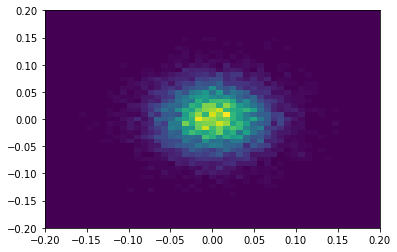

In [14]:
A = 3

xedges = np.linspace(-0.2, 0.2, 50)
yedges = np.linspace(-0.2, 0.2, 50)
heatmap1, xedges1, yedges1 = np.histogram2d(Qpa, Ipa, bins=(xedges, yedges))
heatmap2, xedges1, yedges1 = np.histogram2d(Qma, Ima, bins=(xedges, yedges))
plt.imshow(heatmap1, aspect = 'auto', extent=[xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]])

In [51]:
sigma  = Cov2modes(ADC1,30e6,20e6,t_int)

TypeError: only size-1 arrays can be converted to Python scalars

[ 1.57524996e-03  2.86137312e-05  3.89831446e-06  3.16620286e-05
  2.86137312e-05  1.56602943e-03  3.16620286e-05  5.47206598e-06
  3.89831446e-06  3.16620286e-05  1.60452377e-03 -2.49925501e-05
  3.16620286e-05  5.47206598e-06 -2.49925501e-05  1.61081149e-03]


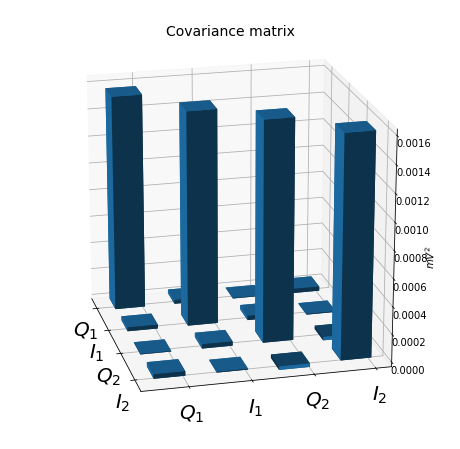

In [52]:
### Plot the covariance matrix

# setup the figure and axes
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='3d')

# # fake data
# x = ['q', 'p']
# y = ['q', 'p']
# xx, yy = np.meshgrid(x, y)

# fake data
_x = np.arange(4)
_y = np.arange(4)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()


sigma_1 = np.ravel(sigma)#[sigma11, sigma21, sigma12, sigma22]
print (sigma_1)
bottom = np.zeros_like(sigma_1)
width = depth = 0.5
ax1.view_init(elev=20, azim = -14)
ax1.bar3d(x, y, bottom, width, depth, sigma_1, shade=True)
ax1.set_title('Covariance matrix', size=14)
plt.xticks([0.2, 1.2, 2.2, 3.3], [r'$Q_1$', r'$I_1$', r'$Q_2$', r'$I_2$'], size = 20) 
plt.yticks([0.5, 1.5, 2.5, 3.5], [r'$Q_1$', r'$I_1$', r'$Q_2$', r'$I_2$'], size = 20)
ax1.set_zlabel(r'$mV^2$')
#ax1.set_zlim(0, 1.0)
plt.savefig('cov2mode_dw0.png')
plt.show()

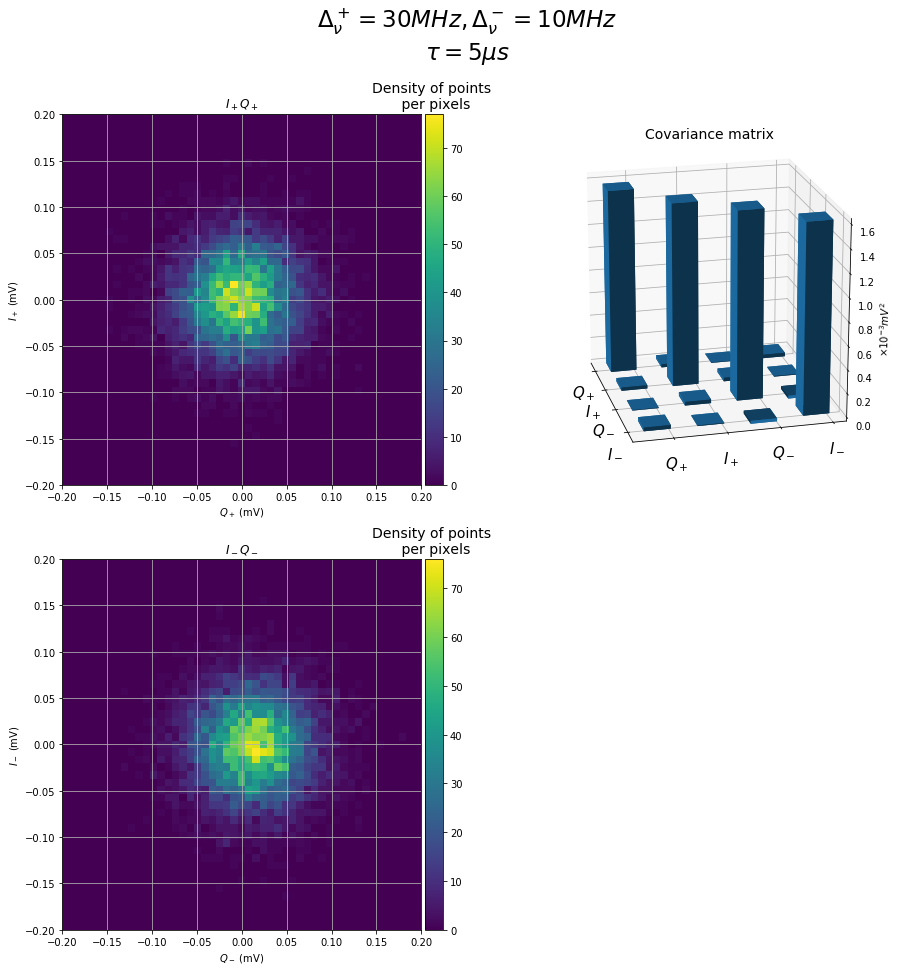

In [28]:
%matplotlib inline
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
d_fn = d_f*1e-6
fig.suptitle(r'$\Delta_\nu^+=30 MHz,\Delta_\nu^-=10 MHz$''\n'r'$\tau = 5\mu{}s$', size=23)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection = '3d')
ax3 = fig.add_subplot(223)
#ax4 = fig.add_subplot(224)
extent=[xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]]
ax1.title.set_text(r'$I_+Q_+$')
ax1.set_xlabel(r'$Q_+$ (mV)')
ax1.set_ylabel(r'$I_+$ (mV)')
ax1.imshow(heatmap1.T,aspect = 'auto', extent=extent, origin='lower')
ax1.grid()
#fig.colorbar(ax1.imshow(heatmap1.T,aspect = 'auto', extent=extent, origin='lower'))
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes('right', size='5%', pad=0.05)
clb1 = fig.colorbar(ax1.imshow(heatmap1.T,aspect = 'auto', extent=extent, origin='lower'), cax=cax1, orientation='vertical')
clb1.ax.set_title('Density of points \n per pixels',size=14)



ax2.title.set_text('Covariance matrix')
_x = np.arange(4)
_y = np.arange(4)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
sigma_1 = np.ravel(sigma*1e3)#[sigma11, sigma21, sigma12, sigma22]
bottom = np.zeros_like(sigma_1)
width = depth = 0.5
ax2.view_init(elev=20, azim = -14)
ax2.bar3d(x, y, bottom, width, depth, sigma_1, shade=True)
ax2.set_title('Covariance matrix', size=14)
ax2.set_xticks([0.2, 1.2, 2.2, 3.3])
ax2.set_xticklabels([r'$Q_+$', r'$I_+$', r'$Q_-$', r'$I_-$'], fontsize = 15)
ax2.set_yticks([0.5, 1.5, 2.5, 3.5],)
ax2.set_yticklabels([r'$Q_+$', r'$I_+$', r'$Q_-$', r'$I_-$'], fontsize = 15)
ax2.set_zlabel(r'$\times 10^{-3} mV^2$')




ax3.title.set_text(r'$I_-Q_-$')
ax3.set_xlabel(r'$Q_-$ (mV)')
ax3.set_ylabel(r'$I_-$ (mV)')
ax3.imshow(heatmap2.T,aspect = 'auto', extent=extent, origin='lower')
#ax3.colorbar(label = 'Density of points per pixels')
ax3.grid()
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes('right', size='5%', pad=0.05)
clb3 = fig.colorbar(ax3.imshow(heatmap2.T,aspect = 'auto', extent=extent, origin='lower'), cax=cax3, orientation='vertical')
clb3.ax.set_title('Density of points \n per pixels',size=14)

fig.savefig('ALL.png')
plt.show()

## Tweak $\Delta_\nu$

In [31]:
N_points = 30
t_int = 5e-6
Ld_f = np.linspace(0,30e6,N_points)
Ld_w = np.linspace(0,2*np.pi*30e6,N_points)
DATAIQ = []
DATAcov = []
for k in range(N_points):
    #DATAIQ.append(IQpm(ADC1,Ld_w[k],t_int))
    DATAcov.append(Cov2modes(ADC1,Ld_w[k],t_int))

TypeError: Cov2modes() missing 1 required positional argument: 't_int'

In [84]:
sig_00 = []
sig_11 = []
sig_22 = []
sig_33 = []

for k in range(N_points):
    sig_00.append(DATAcov[k][0,0])
    sig_11.append(DATAcov[k][1,1])
    sig_22.append(DATAcov[k][2,2])
    sig_33.append(DATAcov[k][3,3])
sig_00 = np.asarray(sig_00)
sig_11 = np.asarray(sig_11)
sig_22 = np.asarray(sig_22)
sig_33 = np.asarray(sig_33) 
Ld_w = np.asarray(Ld_w)


IndexError: list index out of range

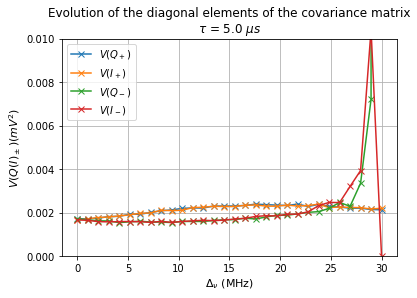

In [20]:
t_intn = t_int*1e6
plt.title('Evolution of the diagonal elements of the covariance matrix\n'r'$\tau$ = %s $\mu{s}$' %t_intn)
plt.plot(Ld_f*1e-6,sig_00,marker='x',label = r'$V(Q_+)$')
plt.plot(Ld_f*1e-6,sig_11,marker='x',label = r'$V(I_+)$')
plt.plot(Ld_f*1e-6,sig_22,marker='x',label = r'$V(Q_-)$')
plt.plot(Ld_f*1e-6,sig_33,marker='x',label = r'$V(I_-)$')
plt.xlabel(r'$\Delta_\nu$ (MHz)',size = 11)
plt.ylabel(r'$V(Q(I)_\pm) (mV^2)$',size = 11)
plt.ylim(0,0.01)
#plt.xlim(0,10)
plt.legend()
plt.grid()
plt.savefig('EvolSigmaDiagZoom2.png',dpi=200)
plt.show()

## Play with integration time

In [33]:
N_points = 30
t_int = np.linspace(0.5e-6,t_final,N_points)
DATAIQ = []
DATAcov = []
for k in range(N_points):
    #DATAIQ.append(IQpm(ADC1,Ld_w[k],t_int))
    DATAcov.append(Cov2modes(ADC1,30e6,10e6,t_int[k]))

In [34]:
sig_00 = []
sig_11 = []
sig_22 = []
sig_33 = []

for k in range(N_points):
    sig_00.append(DATAcov[k][0,0])
    sig_11.append(DATAcov[k][1,1])
    sig_22.append(DATAcov[k][2,2])
    sig_33.append(DATAcov[k][3,3])
sig_00 = np.asarray(sig_00)
sig_11 = np.asarray(sig_11)
sig_22 = np.asarray(sig_22)
sig_33 = np.asarray(sig_33) 
Ld_w = np.asarray(Ld_w)

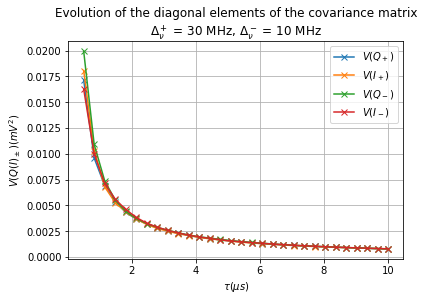

In [37]:
plt.title('Evolution of the diagonal elements of the covariance matrix\n'r'$\Delta_\nu^+$ = 30 MHz, $\Delta_\nu^-$ = 10 MHz')
plt.plot(t_int*1e6,sig_00,marker='x',label = r'$V(Q_+)$')
plt.plot(t_int*1e6,sig_11,marker='x',label = r'$V(I_+)$')
plt.plot(t_int*1e6,sig_22,marker='x',label = r'$V(Q_-)$')
plt.plot(t_int*1e6,sig_33,marker='x',label = r'$V(I_-)$')
plt.xlabel(r'$\tau$($\mu{s}$)')
plt.ylabel(r'$V(Q(I)_\pm) (mV^2)$')
#plt.ylim(0,0.01)
#plt.xlim(0,10)
plt.legend()
plt.grid()
plt.savefig('EvolSigmaDiagINT.png',dpi=200)
plt.show()

## Evaluation of the temperature

$v_n = \sqrt{4k_BTR\Delta_\nu}$ where $\Delta_\nu$ is the bandwidth and $T$ the temperature.\
We can then obtain the power using:
$$
T_1 = \frac{\sigma^2A\tau{}}{RG_1G_2k_B}-T_{RT} - \frac{AT_2}{G_1}
$$


Text(0, 0.5, 'sigma*2tau')

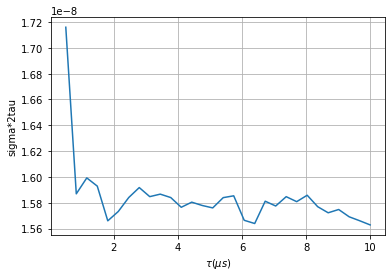

In [38]:
plt.plot(t_int*1e6,sig_00*2*t_int)
plt.grid()
plt.xlabel(r'$\tau (\mu{}s$)')
plt.ylabel('sigma*2tau')

Power spectral density

$$
PSD_3 = \frac{G_1G_2}{A}k_B(T_{RT}+T_1)+G_2\left(1-\frac{1}{A}\right)k_BT_{RT}+G_2k_BT_2
$$

Temperature:

$$
T_1 = \frac{A\left(\frac{V}{BR}-G_2k_B(T_2+T_{RT})\right)}{G_1G_2k_B}+T_{RT}\left(\frac{1}{G_1}-1\right)\pm\delta{A}\frac{\frac{V}{BR}-G_2k_B(T_2+T_{RT})}{G_1G_2k_B}
$$

Where $PSD_3=\frac{V}{BR}$

In [39]:
def T1(tau,dt,sigma,A,R,G1,G2,B,T2):
    k_B = 1.38e-23
    T0 = 290
    return ((sigma*1e-6)*((tau)*A))/(R*G1*G2*k_B)-T0-(T2*A/G1)

def T1a(sigma,tau,R):
    k_B = 1.38e-23
    T0 = 290
    return (sigma*tau)/(R*k_B) - T0

def Tnew(tau,dt,sigma,A,R,G1,G2,B,T2):
    k_B = 1.38e-23
    T0 = 290
    return (((((sigma*1e-6)/(R*B)-G2*k_B*T2)/(G2))-(1-1/A)*k_B*T0)/(((G1)/(A))*k_B))-T0

def Tnew2(tau,dt,sigma,A,R,G1,G2,B,T2):
    k_B = 1.38e-23
    T0 = 290
    return (((sigma*1e-6)/(R*B)-G2*k_B*T2-G2*(1-1/A)*k_B*T2)/(((G1*G2)/A)*k_B))-T0

def Tnew3(tau,sigma,A,R,G1,G2,B,T2):
    k_B = 1.38e-23
    T0 = 290
    return A*((((sigma*1e-6)/(B*R))-G2*k_B*(T2+T0))/(G1*G2*k_B))+T0*((1/G1)-1)

In [26]:
290*((1/G1p)-1)

NameError: name 'G1p' is not defined

In [27]:
plt.plot(T1a(sig_00*1e-6,t_int,R))

NameError: name 'R' is not defined

In [28]:
T1a(sig_00*1e-6,t_int,R)

NameError: name 'R' is not defined

In [43]:
tau = t_int
dt = 8e-9
#sigma = sig_00,11,22,33
A = 10**(6/10)
R = 50
G1p = 10**(12.86/10)#12.86
G2p = 10**(36.66/10)#36.61
G1n = 10**(12.86/10)
G2n = 10**(36.35/10)#36.44
B = 1/tau
T2p = 290*(10**(3.99/10)-1)
T2n = 290*(10**(4.05/10)-1)
sig_00 = 1.61e-3

In [44]:
Tp3 = Tnew3(tau,sig_00,A,R,G1p,G2p,B,T2p)
Tn3 = Tnew3(tau,sig_22,A,R,G1n,G2n,B,T2n)

print(np.average(Tp3),np.average(Tn3))

119.92315368732471 136.39962462401124


In [61]:
dA = 10**(6/10)+0.5
def err3(dA,sigma,tau,G1,G2,R,B,T2):
    k_B = 1.38e-23
    T0 = 290
    return dA*((((sigma*1e-6)/(B*R))-G2*k_B*(T2+T0))/(G1*G2*k_B))

In [62]:
errp3 = err3(dA,sig_00,tau,G1p,G2p,R,B,T2p)
errn3 = err3(dA,sig_33,tau,G1n,G2n,R,B,T2n)
print(np.average(errp3), np.average(errn3))

444.5113300580505 455.75211382178696


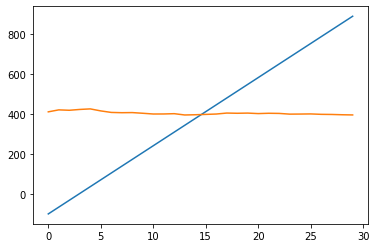

In [60]:
plt.plot(errp3)
plt.plot(errn3)

In [48]:
print('Tp =',np.average(Tp3),'+-', np.average(errp3),'Tn =',np.average(Tn3),'+-', np.average(errn3))

Tp = 119.92315368732471 +- 444.5113300580505 Tn = 136.39962462401124 +- 463.0571521839882


In [32]:
Tp1 = T1(tau,dt,sig_00,A,R,G1p,G2p,B,T2p)
Tn1 = T1(tau,dt,sig_22,A,R,G1n,G2n,B,T2n)

errn1 = err1(dA,dt,sig_00,tau,G1n,G2n,R,B,T2n)
errp1 = err1(dA,dt,sig_22,tau,G1p,G2p,R,B,T2p)

print('Tp =',np.average(Tp1),'+-', np.average(errp1),'Tn =',np.average(Tn1),'+-', np.average(errn1))

NameError: name 'err1' is not defined

In [33]:
plt.plot(Tp)
plt.plot(Tn)

NameError: name 'Tp' is not defined

In [413]:
T2p*A/G1p

80.2147943814912

In [414]:
Tp = T1(tau,dt,sig_00,A,R,G1p,G2p,B,T2p)
Tn = T1(tau,dt,sig_22,A,R,G1n,G2n,B,T2n)
Tp-Tn

array([156.51585222, 185.52370972, 147.55248718, 154.44775556,
       140.59069231, 161.24226728, 160.53017464, 156.60773009,
       154.3010085 , 153.47205344, 147.30496148, 142.86919055,
       146.65601011, 144.43917779, 142.99211802, 147.27257209,
       146.54070706, 144.8824317 , 145.31556921, 142.46671922,
       139.38450486, 140.37747608, 145.22361523, 147.995584  ,
       149.5103961 , 148.22996039, 147.52032616, 146.72488509,
       146.60690708, 144.86128034])

### Error

$$
T_1 = \frac{2\sigma^2A\frac{\tau_{int}}{dt}}{4RG_1G_2k_B1/\tau}-T_{RT} - \frac{AT_2}{G_1} \pm \sqrt{\left(\delta{A}\frac{2\sigma^2\frac{\tau_{int}}{dt}}{4RG_1G_2k_B1/\tau}\right)^2 + \left(\delta{A}\frac{T_2}{G_1}\right)^2}
$$

In [182]:
dA = 10**(0.05/10)
def err1(dA,sigma,tau,dt,G1,G2,R,B,T2):
    k_B = 1.38e-23
    return dA*((2*sigma*((tau)/(dt)))/(R*G1*G2*k_B*B)(T2)/(G1))
def err2(dA,sigma,tau,dt,G1,G2,R,B,T2):
    k_B = 1.38e-23
    return np.sqrt(((dA*sigma*((tau)))/(R*G1*G2*k_B))**2+(dA*(T2)/(G1))**2)

def err3(dA,sigma,tau,G1,G2,R,B,T2):
    k_B = 1.38e-23
    T0 = 290
    return dA*(((sigma*1e-6/(B*R))-G2*k_B*(T2+T0))/(G1*G2*k_B))

err1(dA,sig_00*1e-6,tau,dt,G1p,G2p,R,B,T2p)-err2(dA,sig_00*1e-6,tau,dt,G1p,G2p,R,B,T2p)

array([ 22396.42148099,  38442.17431412,  53479.51968258,  67775.90203287,
        81428.6400948 ,  97376.23040964, 111126.33215176, 124254.21406116,
       138129.0986957 , 153232.86001938, 166767.06397887, 180348.39714857,
       195532.02915605, 209632.39357289, 223077.98925723, 237946.31455581,
       250389.60556547, 264511.60915257, 279874.93868523, 293214.84223111,
       307761.61846338, 322985.79718064, 337621.95004769, 353606.12575116,
       366517.17955209, 378837.53363986, 392455.51604341, 407035.27748015,
       421539.42819605, 434561.97429199])

In [117]:
#Error
errn = err3(dA,sig_00,tau,G1n,G2n,R,B,T2n)
errp = err3(dA,sig_22,tau,G1p,G2p,R,B,T2p)

print(np.average(errn),np.average(errp))

145.77142896492185 92.00544966102959


In [284]:
err = [175]*30

[]

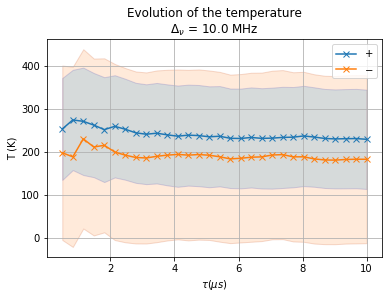

In [285]:
plt.title('Evolution of the temperature\n'r'$\Delta_\nu$ = %s MHz' %d_fn)
plt.plot(t_int*1e6, Tp,marker = 'x', label=r'$+$')
plt.fill_between(t_int*1e6, Tp-errp, Tp+errp,alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.plot(t_int*1e6, Tn,marker = 'x', label = r'$-$')
plt.fill_between(t_int*1e6, Tn-errn, Tn+errn,alpha=0.2,edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel(r'$\tau (\mu{}s$)')
plt.ylabel('T (K)')
plt.grid()
plt.legend()
plt.savefig('TempIntErr.png',dpi=200)
plt.plot()

In [286]:
Tpa = np.average(Tp)
Tna = np.average(Tn)
print(Tpa,Tna,Tpa-Tna)

240.37681122504003 191.18502395173488 49.19178727330515


In [ ]:
tau = 5e-6

In [ ]:
AdB = np.linspace(5,10,30)
AdB = np.asarray(AdB)
A = 10**(AdB/10)

Tp = T1(tau,dt,0.0022e-6,A,R,G1p,G2p,B,T2p)
Tn = T1(tau,dt,0.0018e-6,A,R,G1n,G2n,B,T2n)



In [ ]:
plt.title('Temperatures as a function of the attenuation')
plt.plot(AdB,Tp,label=r'$+$')
plt.plot(AdB,Tn,label=r'$-$')
plt.ylabel(r'T (K)')
plt.xlabel(r'A (dB)')
plt.grid()
plt.legend()
plt.plot()

In [ ]:
plt.title('Difference of temperatures')
plt.plot(AdB,Tp-Tn)
plt.ylabel(r'T (K)')
plt.xlabel(r'A (dB)')
plt.grid()
plt.plot()

In [ ]:
N_points = 3
t_int = 5e-6
Ld_f = np.linspace(0,20e6,N_points)
Ld_w = np.linspace(0,2*np.pi*20e6,N_points)
DATAIQ = []
DATAcov = []
for k in range(N_points):
    DATAIQ.append(IQpm(ADC1,Ld_w[k],t_int))
    DATAcov.append(Cov2modes(ADC1,Ld_w[k],t_int))

In [ ]:
sig_00 = []
sig_11 = []
sig_22 = []
sig_33 = []

for k in range(N_points):
    sig_00.append(DATAcov[k][0,0])
    sig_11.append(DATAcov[k][1,1])
    sig_22.append(DATAcov[k][2,2])
    sig_33.append(DATAcov[k][3,3])
sig_00 = np.asarray(sig_00)
sig_11 = np.asarray(sig_11)
sig_22 = np.asarray(sig_22)
sig_33 = np.asarray(sig_33)
Ld_w = np.asarray(Ld_w)

In [ ]:
G2pdb = [36.53,36.61,36.66]#,36.67
G2ndb = [36.53,36.44,36.35]#,36.69
G2pdb = np.asarray(G2pdb)
G2ndb = np.asarray(G2ndb)
G2p = 10**(G2pdb/10)
G2n = 10**(G2ndb/10)

F2pdb = [3.98,3.99,3.97]
F2ndb = [3.98,4.05,4.14]
F2pdb = np.asarray(F2pdb)
F2ndb = np.asarray(F2ndb)
F2p = 10**(F2pdb/10)
F2n = 10**(F2ndb/10)
T2p = 290*(F2p-1)
T2n = 290*(F2n-1)


In [ ]:
Tp = T1(t_int,dt,sig_00,A,R,G1p,G2p,B,T2p)
Tn = T1(t_int,dt,sig_22,A,R,G1n,G2n,B,T2n)

In [ ]:
t_intn = t_int*1e6
plt.title('Evolution of the diagonal elements of the covariance matrix\n'r'$\tau$ = %s $\mu{s}$' %t_intn)
plt.plot(Ld_f*1e-6,Tp,marker = 'x',label=r'$+$')
plt.plot(Ld_f*1e-6,Tn,marker = 'x',label = r'$-$')
plt.xlabel(r'$\Delta_\nu (MHz)$')
plt.ylabel('T (K)')
plt.grid()
plt.legend()
plt.savefig('TempDelta.png',dpi = 200)
plt.plot()

In [ ]:
def T_Nf(F):
    T0 = 290
    return (F-1)*T0

def Nf_Tot(F1,F2,G1):
    F1l = 10**(F1/10)
    F2l = 10**(F2/10)
    G1l = 10**(G1/10)
    return F1l + (F2l-1)/G1l

In [ ]:
NFp = Nf_Tot(4.9,3.99,12.86)
Nfn = Nf_Tot(4.9,4.05,12.86)

TNp = T_Nf(NFp)
TNn = T_Nf(Nfn)

In [ ]:
d_w = 2*np.pi*10e6
t_int = 5e-6
Sigma = Cov2modes(ADC1,d_w,t_int)

In [ ]:
def T1(tau,dt,sigma,A,R,G1,G2,B,T2):
    k_B = 1.38e-23
    T0 = 290
    return (2*(sigma*1e-6)*((tau))*A)/(R*G1*G2*k_B)-T0-(T2*A/G1)

In [ ]:
tau = t_int
dt = 8e-9
#sigma = sig_00,11,22,33
A = 10**(6/10)
R = 50
G1p = 10**(12.86/10)
G2p = 10**(36.61/10)#36.61
G1n = 10**(12.86/10)
G2n = 10**(36.44/10)#36.44
B = 1/t_int
T2p = 290*(10**(3.99/10)-1)
T2n = 290*(10**(4.05/10)-1)

## along A

In [ ]:
AdB = 6
AdBl = np.linspace(AdB-1,AdB+1,21)
AdBl = np.asarray(AdBl)
Al = 10**(AdBl/10)

Tp = T1(tau,dt,Sigma[0,0],Al,R,G1p,G2p,B,T2p)
Tn = T1(tau,dt,Sigma[2,2],Al,R,G1n,G2n,B,T2n)

In [ ]:
plt.plot(AdBl,Tp)
plt.plot(AdBl,Tn)